In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!cp /content/drive/MyDrive/data/HumanDetection/mipt-x5-lab-2.zip .
!unzip -q mipt-x5-lab-2.zip

## Решение соревнования

In [3]:
import os
import shutil
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import time

from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
print('Данных в train: ', len(os.listdir('/content/train')))
print('Данных в val: ', len(os.listdir('/content/valid')))
print('Данных в test: ', len(os.listdir('/content/test')))

Данных в train:  9003
Данных в val:  1536
Данных в test:  4523


In [5]:
class ClassificationDataset(Dataset):
    def __init__(self, path_to_data, path_to_labels, stage, input_size=224):
        self.path_to_data = path_to_data

        if stage == 'train' or stage == 'valid':
            self.labels = pd.read_csv(path_to_labels)
        else:
            self.labels = None

        # в таком же порядке сохраним пути до файлов
        if self.labels is not None:
            self.file_names = [path_to_data + file_nm for file_nm in self.labels['id']]
        else:
            self.file_names = [
                path_to_data + file_nm for file_nm in sorted(
                    os.listdir(self.path_to_data), key = lambda x: int(x[2:-4])
                )
            ]

        # необходимые трасформации
        self.input_size = input_size
        
        if stage == 'train':
            self._preprocess = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
        else:
            self._preprocess = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

    def __len__(self):
        return len(self.file_names)

    def _load_file(self, path):
        with open(path, 'rb') as input_file:
            with Image.open(input_file) as img:
                return img.convert('RGB')

    def __getitem__(self, idx):
        image = self._load_file(self.file_names[idx])
        image = self._preprocess(image)

        if self.labels is not None:
            return image, self.labels.iloc[idx]['target_people']
        else:
            return image

In [6]:
train_dataset = ClassificationDataset('/content/train/', '/content/train.csv', 'train')
val_dataset = ClassificationDataset('/content/valid/', '/content/valid.csv', 'valid')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
def plot_learning_curves(history, ylim=(2, 4)):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('Лосс', fontsize=15)
    plt.xlabel('Эпоха', fontsize=15)
    plt.legend()
    plt.ylim(ylim)

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['auc']['train'], label='train')
    plt.plot(history['auc']['val'], label='val')
    plt.ylabel('Метрика', fontsize=15)
    plt.xlabel('Эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [8]:
def eval_epoch(model, batch_gen, is_train=False):
    '''
    Одна эпоха обучения/валидации
    '''

    # переменные для хранения loss и метрики
    epoch_loss = 0
    epoch_acc = 0

    model.train(is_train)

    # проходим все данные
    preds = []
    labels = []
    for X_batch, y_batch in tqdm(batch_gen):

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        
        loss = criterion(logits.reshape(-1), y_batch.float().reshape(-1).to(device))

        # если обучаем -- обновляем параметры сети
        if is_train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_loss += np.sum(loss.detach().cpu().numpy())
        preds += logits.detach().cpu().numpy().tolist()
        labels += y_batch.detach().cpu().numpy().tolist()
    
    epoch_loss /= len(batch_gen)
    epoch_auc = roc_auc_score(labels, preds)

    return epoch_loss, epoch_auc

In [9]:
def train(
    model, 
    criterion,
    optimizer, 
    scheduler,
    sch_type,
    train_batch_gen,
    val_batch_gen,
    num_epochs=50,
    ylim=(2, 4)
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))
    
    best_val_loss = np.infty

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_auc = eval_epoch(model, train_batch_gen, True)
        history['loss']['train'].append(train_loss)
        history['auc']['train'].append(train_auc)

        val_loss, val_auc = eval_epoch(model, val_batch_gen, False)
        history['loss']['val'].append(val_loss)
        history['auc']['val'].append(val_auc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training auc: \t\t\t{:.2f} %".format(train_auc * 100))
        print("  validation auc: \t\t\t{:.2f} %".format(val_auc * 100))

        if sch_type == 'plateao':
            scheduler.step(val_loss)
        else:
            scheduler.step()

        plot_learning_curves(history, ylim)
        
    return model, history

In [10]:
class ResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

Epoch 3 of 3 took 418.062s
  training loss (in-iteration): 	0.317325
  validation loss (in-iteration): 	0.395355
  training auc: 			93.36 %
  validation auc: 			90.63 %


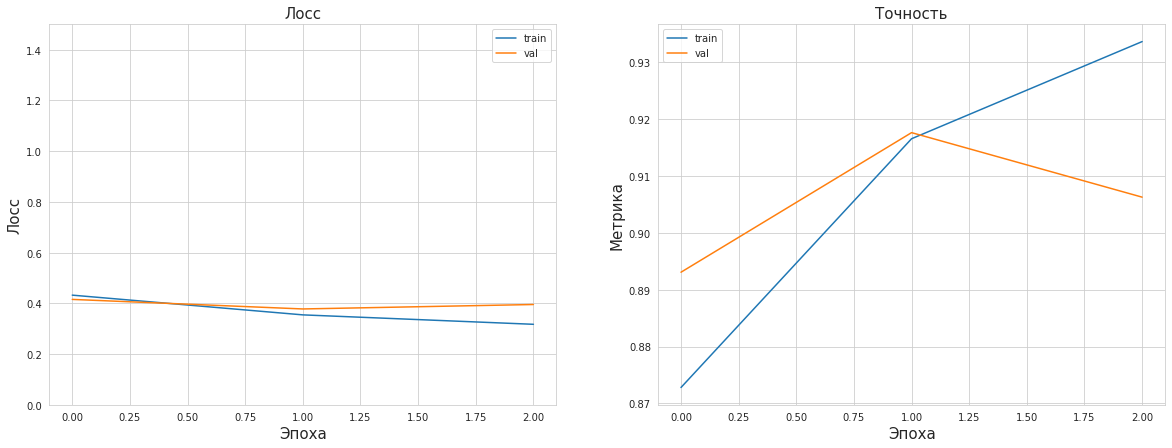

In [11]:
device = torch.device('cuda')

net = ResNet50()
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-04)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3)

net, _ = train(
    net, criterion, optimizer, scheduler, 'plateao',
    train_loader, val_loader, 
    num_epochs=3, ylim=(0, 1.5)
)

Epoch 3 of 3 took 319.245s
  training loss (in-iteration): 	0.230217
  validation loss (in-iteration): 	0.110581
  training auc: 			96.53 %
  validation auc: 			99.42 %


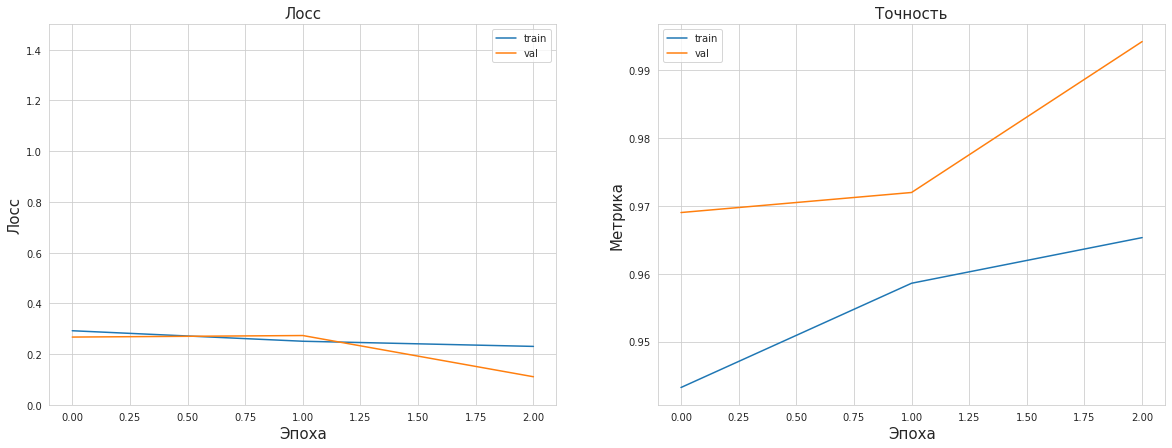

In [ ]:
net, _ = train(
    net, criterion, optimizer, scheduler, 'plateao',
    DataLoader(torch.utils.data.ConcatDataset([train_dataset, val_dataset]), batch_size=32, shuffle=True), val_loader, 
    num_epochs=3, ylim=(0, 1.5)
)

In [ ]:
def get_predicts(model, batch_gen):

    model.train(False)

    preds = []
    for X_batch in tqdm(batch_gen):

        X_batch = X_batch.to(device)

        logits = model(X_batch)
        
        y_pred = logits.detach().cpu().numpy().reshape(-1)

        preds += y_pred.tolist()

    return preds

In [ ]:
test_dataset = ClassificationDataset('/content/test/', None, 'test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

preds = get_predicts(net, test_loader)

  0%|          | 0/142 [00:00<?, ?it/s]

In [ ]:
subm = pd.read_csv('/content/sample_submission.csv')
subm.head()

,id,target_people
0,te0001.jpg,0.5
1,te0002.jpg,0.5
2,te0003.jpg,0.5
3,te0004.jpg,0.5
4,te0005.jpg,0.5


In [ ]:
subm['target_people'] = 1 / (1 + np.exp(-np.array(preds)))

In [ ]:
subm.to_csv('answer.csv', index=False)